# RNN to map SMILES to Fragment Peaks

See https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
from glob import glob
import pylab as plt
import pandas as pd
import numpy as np
import pickle

from keras import layers
from keras.models import Sequential
from six.moves import range
from livelossplot import PlotLossesKeras

from IPython.display import display, HTML
from collections import defaultdict

from rdkit import Chem

Using TensorFlow backend.



### Load data

In [3]:
def load_data(input_file):
    with open(input_file, 'r') as f:
        data = []
        for line in f:
            tokens = line.split('\t')
            smile = tokens[0].strip()
            spectra = tokens[1].strip().split(',')
            data.append((smile, spectra, ))
        return data

In [4]:
def get_vocab(data):
    vocab = set()
    for smile, spectra in data:
        spectra = sorted(list(set(spectra)))        
        vocab.update(smile)
        for mz in spectra:
            vocab.add(mz)
    vocab.add(' ')
    return sorted(list(vocab))

In [18]:
data = load_data('data/data_small.txt')
data = data[0:1000]
vocab = get_vocab(data)
token_indices = dict((c, i) for (c, i) in enumerate(vocab))
indices_token = dict((i, c) for (c, i) in enumerate(vocab))
print(len(data))
print(len(vocab))
print(vocab)

1000
247
[' ', '#', '(', ')', '+', '-', '/', '1', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', 

In [19]:
x, y = zip(*data)
len_x = list(map(len, x))
len_y = list(map(len, y))
MAX_LEN = max(len_x + len_y)
TRAINING_SIZE = len(data)

In [21]:
padded_data = []
for x, y in data:
    if len(x) < MAX_LEN:
        print(x)
        print(y)
        print()        
        x = x + ' ' * (MAX_LEN - len(x))
        y = y + [' ' for x in range(MAX_LEN - len(y))]
        assert(len(x) == len(y))
        padded_data.append((x, y, ))

Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1
['156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '157', '157', '157', '158', '158', '158', '176', '176', '176', '185', '185', '185', '251', '251', '251', '251', '251', '251', '251', '251', '251', '251', '251', '251', '252']

Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1
['156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156', '156',

In [22]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """

    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.

        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True, join_char=''):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return join_char.join(self.indices_char[x] for x in x)

In [23]:
c_table = CharacterTable(vocab)
chars = vocab

questions = []
expected = []
for smile, spectra in padded_data:
    spectra = list(map(str, spectra))
    questions.append(smile)
    expected.append(spectra)

In [24]:
x = np.zeros((len(questions), MAX_LEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), MAX_LEN, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = c_table.encode(sentence, MAX_LEN)
for i, sentence in enumerate(expected):
    y[i] = c_table.encode(sentence, MAX_LEN)

In [25]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

In [26]:
print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(900, 100, 247)
(900, 100, 247)
Validation Data:
(100, 100, 247)
(100, 100, 247)


### Define Model

In [27]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 100
BATCH_SIZE = 100
LAYERS = 1
EPOCHS = 10

In [28]:
model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAX_LEN, len(chars))))

# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(MAX_LEN))

# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               139200    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 247)          24947     
_________________________________________________________________
activation_1 (Activation)    (None, 100, 247)          0         
Total params: 244,547
Trainable params: 244,547
Non-trainable params: 0
_________________________________________________________________


### Train

In [29]:
# history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

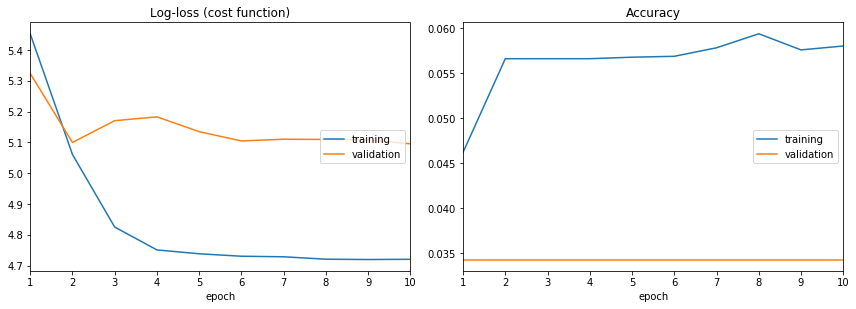

In [30]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val),
                    callbacks=[PlotLossesKeras()])

Doesn't work because of the fixed length padding. The model predicts space all the time?

In [31]:
# Select 10 samples from the validation set at random
for i in range(10):
    
    ind = np.random.randint(0, len(x_val))
    rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]    
    preds = model.predict_classes(rowx, verbose=0)
    
    q = c_table.decode(rowx[0])
    correct = c_table.decode(rowy[0], join_char=' ')
    guess = c_table.decode(preds[0], calc_argmax=False, join_char=' ')
    print('Query', q)    
    print('Actual Answer', correct)    
    print('Predicted Answer ***', guess, '***')
    print()

Query O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl                                                                      
Actual Answer 180 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 214 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215 215    
Predicted Answer *** 134 134 134 134 134 134 134                                                                                                                                                                                           ***

Query CC(C)Cc1ccc(C(C)C(=O)O)cc1                                                                          
Actual Answer 147 147 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 161 16

In [23]:
model.save('results/rnn_small.hdf5')
with open('results/rnn_small.history', 'wb') as f:
    pickle.dump(history.history, f)